In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import lightkurve as lk
from scipy.optimize import curve_fit
import pandas as pd
from scipy.interpolate import make_interp_spline as spline
import math

In [2]:
TIC = 'TIC 3034524' 

data_all = lk.search_lightcurve(TIC, author='SPOC')

data_all


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 19,2019,SPOC,120,3034524,0.0
1,TESS Sector 43,2021,SPOC,120,3034524,0.0
2,TESS Sector 44,2021,SPOC,120,3034524,0.0
3,TESS Sector 45,2021,SPOC,120,3034524,0.0
4,TESS Sector 59,2022,SPOC,120,3034524,0.0
5,TESS Sector 71,2023,SPOC,120,3034524,0.0
6,TESS Sector 73,2023,SPOC,120,3034524,0.0


0 243
243 435
435 677
677 909
909 1153
1153 1408
1408 1664
1664 1921
1921 2178
2178 2436
2436 2694
2694 2952
2952 3209
3209 3463
3463 3710
3710 3960
3960 4218
4218 4476
4476 4734
4734 4991
4991 5249
5249 5507
5507 5765
5765 6023
6023 6281
6281 6539
6539 6797
6797 7055
7055 7305
7305 7561
7561 7816
7816 8074
8074 8331


/var/folders/dj/s7s773g53wg44p006fln3znw0000gn/T/ipykernel_79137/4247263031.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(gaussian_function, x, y, p0=initial_guess)


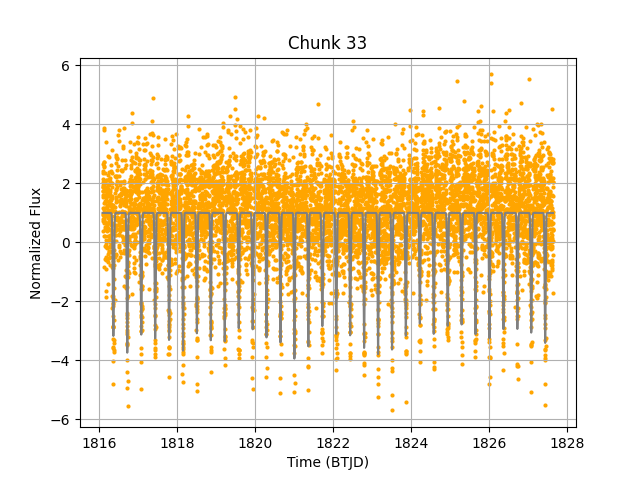

In [78]:
#Fitting a Gaussian to the light curve

plt.figure()

new = pd.DataFrame({'x_fit' : 1,'y_fit' : 1}, index=[0])
x_fit = np.empty(0)
y_fit = np.empty(0)

TIC = 'TIC 3034524' 

data_all = lk.search_lightcurve(TIC, author='SPOC')

data = data_all[0]

lc = data.download_all().stitch()

# Define the Gaussian function
def gaussian_function(x, A, mu, sigma):
    return -(A * np.exp(-((x - mu)**2) / (2 * sigma**2))-1)

def process_chunk(start_index, end_index, mu_fit):
    print(start_index, end_index)
    Times = lc.time[start_index:end_index]
    t = Time(Times)
    x = np.array(t.btjd)
    y = np.array(lc.flux[start_index:end_index])
    
    # Remove invalid values (infs and NaNs) from y and x arrays
    mask_valid = ~np.isnan(y) & ~np.isinf(y)
    x = x[mask_valid]
    y = y[mask_valid]
    
    while len(x) > 3:
        # Fitting the curve to the data
        initial_guess = [10, mu_fit, 0.17]  # Assume initial values for A, μ and σ
        params, covariance = curve_fit(gaussian_function, x, y, p0=initial_guess)

        # Get fitted values for A, μ and σ
        A_fit, mu_fit, sigma_fit = params

        # Get the diagonals of the covariance matrix as the variances of A, μ and σ
        var_A_fit, var_mu_fit, var_sigma_fit = np.diag(covariance)

        # Create points for the fitted curve
        x_fit = np.linspace(min(x), max(x), 1000)
        y_fit = gaussian_function(x_fit, A_fit, mu_fit, sigma_fit)

        df = pd.DataFrame({'x_fit' : pd.Series(x_fit),
        'y_fit': pd.Series(y_fit)})

        global new

        new = pd.concat([new, df], ignore_index=True)

        # Calculate the errors as the square root of the variances
        error_A_fit = np.sqrt(var_A_fit)
        error_mu_fit =  np.sqrt(var_mu_fit)
        error_sigma_fit = np.sqrt(var_sigma_fit)

        # Smooth the data (uncomment the bottom 3 lines to see the smoothed curve)
        # xnew = np.linspace(x.min(), x.max(), 1000)  
        # spl = spline(x, y, k=3)
        # y_smooth = spl(xnew)

        # plt.figure()                                  #uncomment to see each chunk separately
        plt.scatter(x, y, linewidth=0, color='orange', marker='.') #comment this line to see the smoothed curve
        # plt.plot(xnew,y_smooth, linewidth=0.5)        #uncomment this line to see the smoothed curve
        plt.plot(x_fit, y_fit, color='gray')
        plt.title('Chunk ' + str(i))
        plt.xlabel('Time (BTJD)')
        plt.ylabel('Normalized Flux')
        plt.grid(True)

        # print("\nParameters and their errors", i, ":")
        # print("A =", A_fit, "+/-", error_A_fit)
        # print("mu =", mu_fit, "+/-", error_mu_fit)
        # print("Sigma =", sigma_fit, "+/-", error_sigma_fit, "\n")
        # return [mu_fit, x_fit, y_fit]
        return mu_fit
    if len(x) <= 3:
        mu_guess=1829
        initial_guess = [A_guess, mu_guess, sigma_guess]
        mu_fit = initial_guess[1]

        # return [mu_fit, x_fit, y_fit]
        return mu_fit
    
# Define initial guesses for A, mu, and sigma
A_guess = 10
mu_guess = 1816.3
sigma_guess = 0.17

# Create the initial_guess list
initial_guess = [A_guess, mu_guess, sigma_guess]

# Get the period in julian days
period_julian_days = 0.357452436602186

# Initialize mu_fit with the initial guess value for mu
mu_fit = initial_guess[1]

# Iterate through the light curve and process chunks of data with the given period
start_index = 0
i=1

while start_index < 8200:  #uncomment this line to limit for testing purposes
# while start_index < len(lc):
    end_time = lc.time[start_index] + period_julian_days         
    end_index = np.searchsorted(lc.time, end_time, side='right')   #basically just tells which index 'end_time' would be if it existed in lc.time. eg: If lc.time was [2.03, 2.05. 2.1], and end_time was 2.08175732, it would return 2 (the 'hypothetical' index). The above line defines end_time, in a weirdly hardwired way, and this line tells the index of that.
    
    # Call process_chunk with the updated mu_fit value
    # processed = process_chunk(start_index, end_index, mu_fit)
    # mu_fit = processed[0]
    mu_fit = process_chunk(start_index, end_index, mu_fit)
    # x_fit = np.append(x_fit, processed[1])
    # y_fit = np.append(y_fit, processed[2])
    mu_fit = mu_fit + period_julian_days   
    
    #Update the start_index for the next iteration
    start_index = end_index
    i=i+1

new.drop(new.index[0], inplace=True)
new.to_csv('Data Files/fitted_curve.csv', index=False)
del new

plt.show()

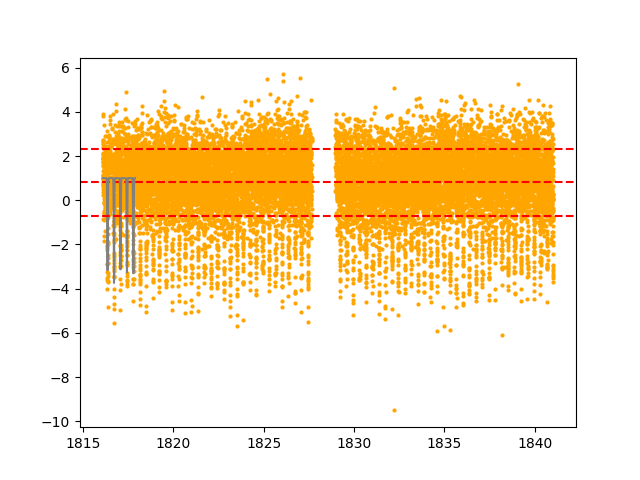

In [8]:
TIC = 'TIC 3034524' 

data_all = lk.search_lightcurve(TIC, author='SPOC')

data = data_all[0]

lc = data.download_all().stitch()


Times = lc.time
t = Time(Times)
x = np.array(t.btjd)
y = np.array(lc.flux)

plt.figure()
plt.scatter(x, y, linewidth=0, color='orange', marker='.') #comment this line to see the smoothed curve

mask_valid = ~np.isnan(y) & ~np.isinf(y)
x_test = x[mask_valid]
y_test= y[mask_valid]

mean_y_test = np.mean(y_test)
plt.axhline(y=mean_y_test, color='red', linestyle='--')

plt.plot(x_fit, y_fit, color='gray')

std_y_test = np.std(y_test)

plt.axhline(y=mean_y_test - std_y_test, color='red', linestyle='--')

plt.axhline(y=mean_y_test + std_y_test, color='red', linestyle='--')







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_fit   33000 non-null  float64
 1   y_fit   33000 non-null  float64
dtypes: float64(2)
memory usage: 515.8 KB
None


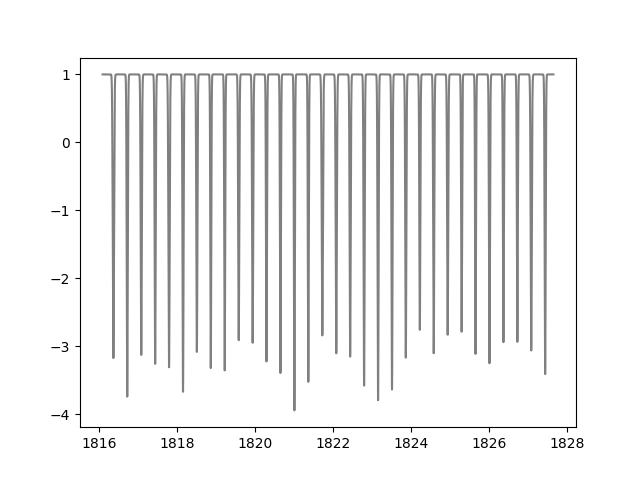

In [71]:
#Reads the fitted curve data 

fitted_curve = pd.read_csv('Data Files/fitted_curve.csv')
print(fitted_curve.info())


# Plot the fitted curve
plt.figure()
plt.plot(fitted_curve['x_fit'], fitted_curve['y_fit'], color='gray')


In [75]:
from scipy.signal import find_peaks

#invert the curve to find peaks
fitted_curve['inverted_y_fit'] = -fitted_curve['y_fit']

# Find peaks in the inverted_y_fit column
peaks, _ = find_peaks(fitted_curve['inverted_y_fit'], )

# Get the x_fit values corresponding to the peaks
peak_x_values = fitted_curve['x_fit'][peaks]

# Print the peak x_fit values
print(peak_x_values)

# Calculate the period
periods = np.diff(peak_x_values)


777      1816.367424
1771     1816.723625
2774     1817.083042
3770     1817.439957
4763     1817.795799
5765     1818.154857
6756     1818.509984
7753     1818.867255
8751     1819.224883
9755     1819.584654
10752    1819.941924
11743    1820.297049
12742    1820.655033
13741    1821.013016
14738    1821.370285
15740    1821.729340
16738    1822.086965
17734    1822.443875
18733    1822.801857
19733    1823.160196
20731    1823.517820
21719    1823.871871
22724    1824.231996
23718    1824.588190
24718    1824.946527
25716    1825.304150
26713    1825.661415
27711    1826.019037
28709    1826.376659
29708    1826.734637
30701    1827.090472
31699    1827.448093
Name: x_fit, dtype: float64


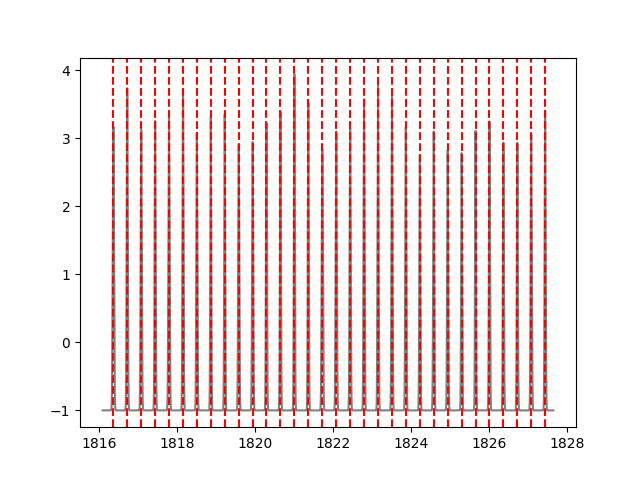

In [73]:
#MEANT FOR TESTING PURPOSES: checking if the peaks from the function are correct

plt.figure()
new_plot = plt.plot(fitted_curve['x_fit'], fitted_curve['inverted_y_fit'], color='gray')
for x in peak_x_values:
    plt.axvline(x=x, color='red', linestyle='--')
plt.show()

In [74]:
periods

array([0.35620123, 0.35941654, 0.35691489, 0.35584254, 0.35905796,
       0.35512717, 0.3572707 , 0.35762768, 0.35977122, 0.35726973,
       0.35512556, 0.35798374, 0.35798344, 0.35726852, 0.35905477,
       0.35762524, 0.35691034, 0.35798197, 0.35833899, 0.35762408,
       0.35405072, 0.36012465, 0.35619398, 0.35833752, 0.35762261,
       0.35726501, 0.35762201, 0.3576217 , 0.3579787 , 0.35583456,
       0.3576208 ])

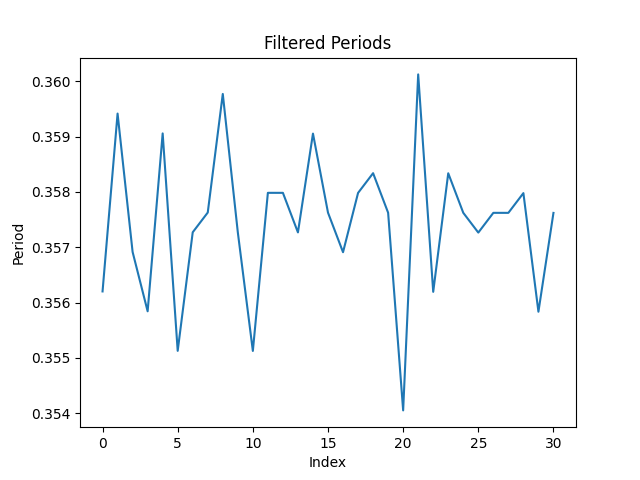

In [54]:
import numpy as np

import matplotlib.pyplot as plt

# Remove outliers from periods
def remove_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    filtered_data = [x for x in data if (mean - threshold * std < x < mean + threshold * std)]
    return filtered_data

filtered_periods = remove_outliers(periods)

# Plot the updated periods
plt.figure()
plt.plot(filtered_periods)
plt.xlabel('Index')
plt.ylabel('Period')
plt.title('Filtered Periods')
plt.show()


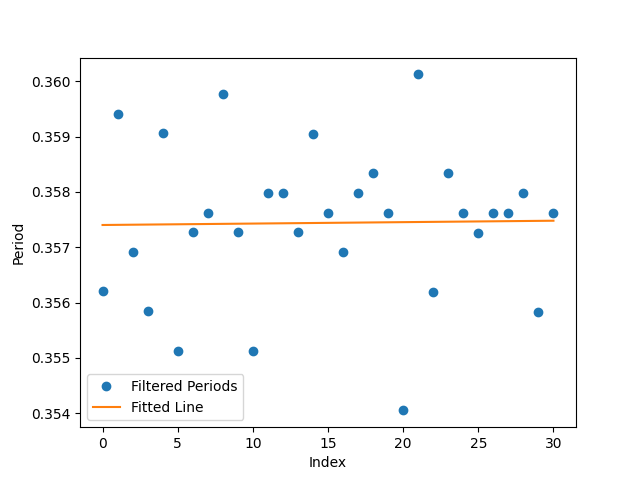

In [55]:
import numpy as np

import matplotlib.pyplot as plt
# Convert filtered_periods to numpy array
filtered_periods = np.array(filtered_periods)

# Generate x values (indices)
x = np.arange(len(filtered_periods))

# Fit a straight line using numpy.polyfit
slope, intercept = np.polyfit(x, filtered_periods, 1)

# Generate y values for the fitted line
y_fit = slope * x + intercept

# Plot the original data and the fitted line
plt.figure()
plt.plot(x, filtered_periods, 'o', label='Filtered Periods')
plt.plot(x, y_fit, label='Fitted Line')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Period')
plt.legend()

# Show the plot
plt.show()

In [79]:
slope

2.572260786426814e-06